In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as pylab
import geopandas as gpd
plt.style.use('ggplot')

In [40]:
# load the data
cases_raw = pd.read_csv('data/line-list-nigeria.csv')
health_raw = pd.read_csv('data/healthmopupandbaselinenmisfacility.csv')
pop_raw = pd.read_csv('data/nga_pop_adm1_2016.csv')

In [41]:
# make some copies
cases = cases_raw.copy()
pop = pop_raw.copy()
health = health_raw.copy()

In [42]:
# most columns contain little useful information and are empty. keep only the useful stuff
cases = cases[['case_id', 'date', 'province/state']]

In [43]:
# date is an object, convert to datetime
cases['date_dt'] = pd.to_datetime(cases['date'])

In [44]:
# do some useful aggregations - group by day and week on national and state level
daily_state = cases.groupby('province/state').resample('D', on='date_dt')['case_id'].count().reset_index(name='cases')
weekly_state = cases.groupby('province/state').resample('W-Mon', on='date_dt')['case_id'].count().reset_index(name='cases')

daily = cases.resample('D', on='date_dt')['case_id'].count().reset_index(name='cases')
daily['7_day_avg'] = daily.rolling(window=7).mean()
weekly = cases.resample('W-Mon', on='date_dt')['case_id'].count().reset_index(name='cases')

# also get the total cases for each state
cases_by_state = weekly_state.groupby('province/state')['province/state','cases'].sum()

In [45]:
weekly_state

province/state    date_dt  cases
0             Abia 2020-04-20      2
1             Abia 2020-04-27      0
2             Abia 2020-05-04      0
3             Abia 2020-05-11      0
4             Abia 2020-05-18      3
..             ...        ...    ...
231           Yobe 2020-05-18     19
232        Zamfara 2020-04-27      2
233        Zamfara 2020-05-04     11
234        Zamfara 2020-05-11     60
235        Zamfara 2020-05-18     11

[236 rows x 3 columns]

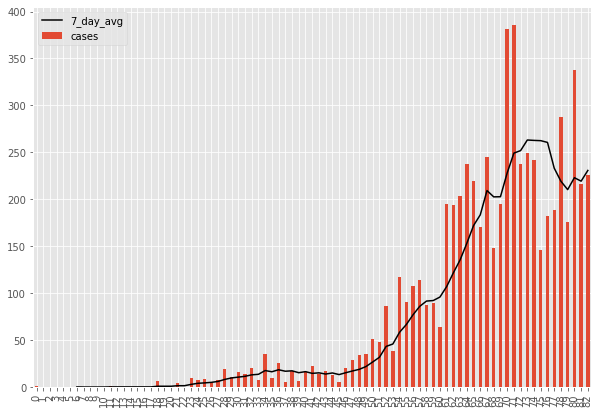

In [46]:
# quick and dirty plot of daily cases and the 7 day rolling average
fig, ax = plt.subplots(figsize=(10,7))

daily.plot(y=['7_day_avg'], kind='line', ax=ax, c='k')
daily.plot(y=['cases'], kind='bar', ax=ax, stacked=True)

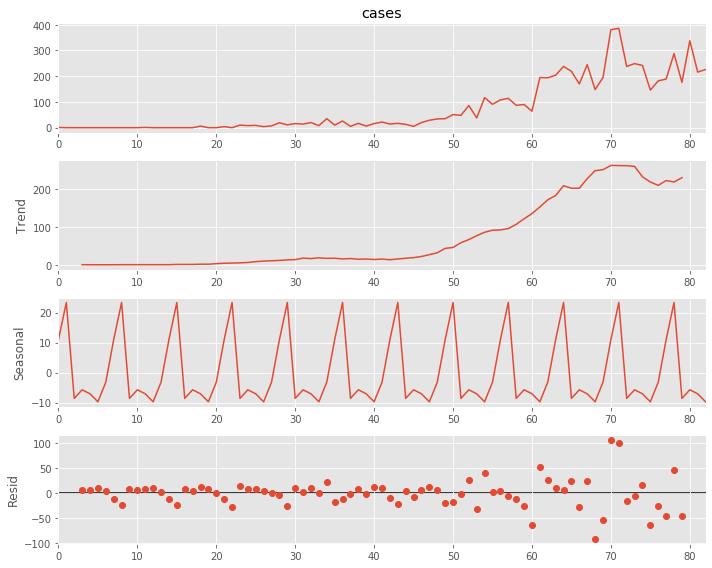

In [47]:
# check for any trends. overall increasing - small seasonal component (e.g. from inconsistent reporting) is small. 
pylab.rcParams['figure.figsize'] = (10, 8)

res = sm.tsa.seasonal_decompose(daily['cases'],period=7)
resplot = res.plot()

In [48]:
pop = pop[['admin1Name_en', 'Unnamed: 1', 'Unnamed: 4']].rename(columns={'Unnamed: 1': 'state_code', 'Unnamed: 4': 'population'})

In [68]:
# join the weekly data with population. calculate a case rate per population.
weekly_state_pop = weekly_state.set_index('province/state').join(
                    pop[['admin1Name_en', 'population']].set_index('admin1Name_en')
                    ).reset_index().rename(columns={'index': 'province/state'})

In [69]:
weekly_state_pop['case_rate_100k'] = (weekly_state_pop['cases']/weekly_state_pop['population'])*100000

In [70]:
weekly_state_pop = weekly_state_pop

In [71]:
weekly_state_pop.head(10)

province/state    date_dt  cases  population  case_rate_100k
0           Abia 2020-04-20      2   3644714.0        0.054874
1           Abia 2020-04-27      0   3644714.0        0.000000
2           Abia 2020-05-04      0   3644714.0        0.000000
3           Abia 2020-05-11      0   3644714.0        0.000000
4           Abia 2020-05-18      3   3644714.0        0.082311
5          Abuja 2020-03-23      7         NaN             NaN
6          Abuja 2020-03-30     18         NaN             NaN
7          Abuja 2020-04-06     23         NaN             NaN
8          Abuja 2020-04-13      8         NaN             NaN
9          Abuja 2020-04-20     33         NaN             NaN

In [52]:
# do the same for the national data - will be useful to see which states are above/below national averages
weekly['case_rate_100k'] = (weekly['cases']/pop['population'].sum())*100000

In [53]:
weekly

date_dt  cases  case_rate_100k
0  2020-03-02      1        0.000533
1  2020-03-09      1        0.000533
2  2020-03-16      6        0.003195
3  2020-03-23     31        0.016508
4  2020-03-30     91        0.048460
5  2020-04-06    107        0.056981
6  2020-04-13    107        0.056981
7  2020-04-20    321        0.170942
8  2020-04-27    671        0.357327
9  2020-05-04   1465        0.780155
10 2020-05-11   1839        0.979320
11 2020-05-18   1535        0.817432
12 2020-05-25    226        0.120351

# Create a map based dashboard

In [54]:
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json
from urllib.request import urlopen


In [55]:
init_notebook_mode(connected=True)

In [18]:
cases_by_state = daily_state.groupby('province/state')['province/state','cases'].sum().reset_index()

In [19]:
cases_by_state = cases_by_state.set_index('province/state').join(
                    pop[['admin1Name_en', 'state_code']].set_index('admin1Name_en')
                    ).reset_index().rename(columns={'index': 'province/state'})

In [56]:
weekly_state_pop_code = weekly_state_pop.set_index('province/state').join(
                    pop[['admin1Name_en', 'state_code']].set_index('admin1Name_en')
                    ).reset_index().rename(columns={'index': 'province/state'})

In [57]:
weekly_state_pop_code

province/state    date_dt  cases  population  case_rate_100k state_code
0             Abia 2020-04-20      2   3644714.0        0.054874      NG001
1             Abia 2020-04-27      0   3644714.0        0.000000      NG001
2             Abia 2020-05-04      0   3644714.0        0.000000      NG001
3             Abia 2020-05-11      0   3644714.0        0.000000      NG001
4             Abia 2020-05-18      3   3644714.0        0.082311      NG001
..             ...        ...    ...         ...             ...        ...
231           Yobe 2020-05-18     19   3197296.0        0.594252      NG036
232        Zamfara 2020-04-27      2   4376911.0        0.045694      NG037
233        Zamfara 2020-05-04     11   4376911.0        0.251319      NG037
234        Zamfara 2020-05-11     60   4376911.0        1.370830      NG037
235        Zamfara 2020-05-18     11   4376911.0        0.251319      NG037

[236 rows x 6 columns]

In [60]:
# replace the missing state code - Abuja which is sometimes refered to as FCT (federal capital territory)
weekly_state_pop_code.loc[weekly_state_pop_code['province/state'] == 'Abuja', 'state_code'] = 'NG015'

In [61]:
weekly_state_pop_code.head(10)

province/state    date_dt  cases  population  case_rate_100k state_code
0           Abia 2020-04-20      2   3644714.0        0.054874      NG001
1           Abia 2020-04-27      0   3644714.0        0.000000      NG001
2           Abia 2020-05-04      0   3644714.0        0.000000      NG001
3           Abia 2020-05-11      0   3644714.0        0.000000      NG001
4           Abia 2020-05-18      3   3644714.0        0.082311      NG001
5          Abuja 2020-03-23      7         NaN             NaN      NG015
6          Abuja 2020-03-30     18         NaN             NaN      NG015
7          Abuja 2020-04-06     23         NaN             NaN      NG015
8          Abuja 2020-04-13      8         NaN             NaN      NG015
9          Abuja 2020-04-20     33         NaN             NaN      NG015

In [22]:
with urlopen('https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/145474/ngaadmbndaadm1osgof20161215.geojson') as response:
    nigeria_map = json.load(response)

In [25]:
print(cases_by_state["province/state"][2])
print(nigeria_map["features"][2]["properties"])

Adamawa
{'admin1Name': 'Akwa Ibom', 'admin1Pcod': 'NG003', 'admin1RefN': 'Akwa Ibom', 'admin1AltN': None, 'admin1Al_1': None, 'admin0Name': 'Nigeria', 'admin0Pcod': 'NG', 'date': '2016/11/29', 'validOn': '2016/12/15', 'validTo': None, 'Shape_Leng': 5.26383, 'Shape_Area': 0.549476}


In [28]:
import plotly.express as px

fig = px.choropleth(cases_by_state, geojson=nigeria_map, color="cases",
                    locations="state_code", featureidkey="properties.admin1Pcod",
                    projection="mercator",
                    hover_name = 'province/state',
                    animation_frame='year',
                    range_color=[20,80]
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
# missing data for Kogi state - appears to be due to lack of reporting
# https://www.premiumtimesng.com/news/headlines/432825-covid-19-while-nigerias-new-cases-surge-kogi-yet-to-report-new-infection-in-175-days.html